# Source Bias & Domain Quality Analysis

**Goal:** Investigate patterns in news source behavior to identify potential biases and quality signals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

In [2]:
# Load data
from pathlib import Path

# Find project root by walking up from current directory until we find 'data' directory
# Works whether notebook is run from project root or from a subdirectory
current = Path.cwd()
while not (current / "data").exists() and current != current.parent:
    current = current.parent
PROJECT_ROOT = current
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
INPUT_PATH = PROCESSED_DIR / "gdelt_ohlcv_join.csv"

df = pd.read_csv(INPUT_PATH, parse_dates=["seendate"])
assert "sentiment_score" in df.columns, "Input CSV must have a 'sentiment_score' column."
print(f"Loaded {len(df):,} rows from {INPUT_PATH.name}")

print(f"Date range: {df['seendate'].min().date()} to {df['seendate'].max().date()}")
print(f"\nUnique domains: {df['domain'].nunique()}")

Loaded 5,167 rows from gdelt_ohlcv_join.csv
Date range: 2026-01-06 to 2026-02-16

Unique domains: 803


## **Domain Concentration: Who Controls the Narrative?**

Understanding if our sentiment signal is dominated by a few sources vs. diversified across many.

In [5]:
# Domain coverage analysis
domain_counts = df['domain'].value_counts()
total_articles = len(df)

# Top 15 domains
top_domains = domain_counts.head(15)
top_domains_pct = (top_domains / total_articles * 100).round(1)

# Concentration metrics
top_5_coverage = (domain_counts.head(5).sum() / total_articles * 100)
top_10_coverage = (domain_counts.head(10).sum() / total_articles * 100)


print("=" * 50)
print("Domain Concentration:")
print("=" * 50)
print(f"Top 5 domains cover: {top_5_coverage:.1f}% of all articles")
print(f"Top 10 domains cover: {top_10_coverage:.1f}% of all articles")
print(f"\nTotal unique domains: {len(domain_counts)}")
print(f"\nDomains with only 1 article: {(domain_counts == 1).sum()}")
print(f"Domains with 10+ articles: {(domain_counts >= 10).sum()}")

print("=" * 60)
print("Top 15 Domains by Article Count:")
print("=" * 60)
for domain, count in top_domains.items():
    pct = (count / total_articles * 100)
    print(f"{domain:40s} {count:4d} articles ({pct:5.1f}%)")

Domain Concentration:
Top 5 domains cover: 41.7% of all articles
Top 10 domains cover: 51.6% of all articles

Total unique domains: 803

Domains with only 1 article: 453
Domains with 10+ articles: 55
Top 15 Domains by Article Count:
finance.yahoo.com                         902 articles ( 17.5%)
markets.financialcontent.com              481 articles (  9.3%)
fool.com                                  437 articles (  8.5%)
webpronews.com                            182 articles (  3.5%)
benzinga.com                              154 articles (  3.0%)
themarketsdaily.com                       118 articles (  2.3%)
economictimes.indiatimes.com              112 articles (  2.2%)
insidermonkey.com                         111 articles (  2.1%)
cnbc.com                                   86 articles (  1.7%)
tickerreport.com                           83 articles (  1.6%)
dailypolitical.com                         80 articles (  1.5%)
marketscreener.com                         61 articles (  1.2%)

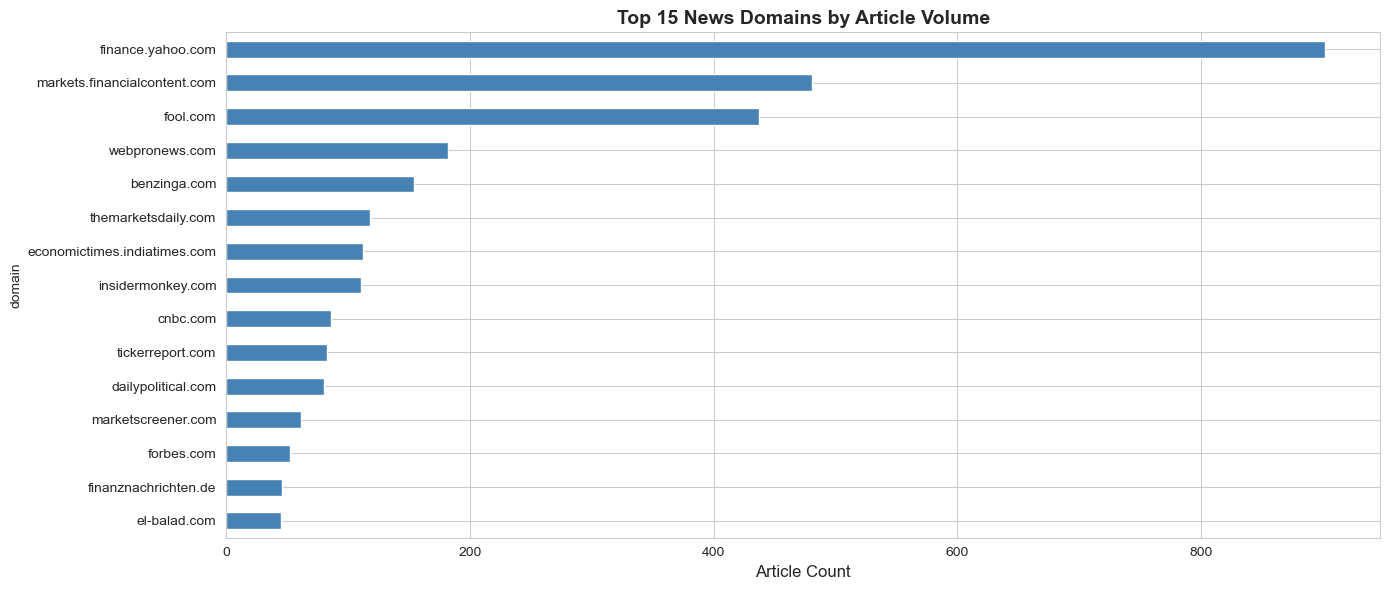

In [6]:
# Visualization: Domain concentration
fig, ax1 = plt.subplots(figsize=(14, 6))

# Top 15 domains bar chart
top_domains.plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Article Count', fontsize=12)
ax1.set_title('Top 15 News Domains by Article Volume', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

plt.tight_layout()
plt.show()

## **Sentiment Bias by Domain**

Do certain sources systematically lean positive or negative?

In [7]:
# Calculate sentiment statistics by domain (for domains with 10+ articles)
domain_sentiment = df.groupby('domain').agg({
    'sentiment_score': ['mean', 'std', 'count'],
    'sentiment_present': 'mean'
}).round(3)

domain_sentiment.columns = ['avg_sentiment', 'std_sentiment', 'article_count', 'pct_with_sentiment']
domain_sentiment = domain_sentiment[domain_sentiment['article_count'] >= 10].sort_values('avg_sentiment', ascending=False)


print("Sentiment Bias by Domain (10+ articles only)")
print("=" * 80)
print(f"\nMost POSITIVE domains:")
print(domain_sentiment.head(10).to_string())

print(f"\nMost NEGATIVE domains:")
print(domain_sentiment.tail(10).to_string())

Sentiment Bias by Domain (10+ articles only)

Most POSITIVE domains:
                        avg_sentiment  std_sentiment  article_count  pct_with_sentiment
domain                                                                                 
fool.com                        0.382          0.517            437               0.551
fool.com.au                     0.373          0.483             10               0.400
econotimes.com                  0.358          0.726             10               0.900
seekingalpha.com                0.337          0.514             14               0.571
247wallst.com                   0.327          0.642             14               0.786
prnewswire.com                  0.316          0.375             13               0.462
proactiveinvestors.com          0.283          0.617             18               0.667
insidermonkey.com               0.251          0.441            111               0.360
bnnbloomberg.ca                 0.250          0.55

## **3. Volume vs. Sentiment Relationship**

Do high-volume sources show more neutral sentiment (balanced reporting)?
Or do they lean towards sensationalism?

In [8]:
domain_stats = df.groupby('domain').agg({
    'sentiment_score': 'mean',
    'url': 'count'
}).rename(columns={'url': 'article_count', 'sentiment_score': 'avg_sentiment'})

domain_stats = domain_stats[domain_stats['article_count'] >= 5]

# Add absolute sentiment (distance from neutral)
domain_stats['abs_sentiment'] = domain_stats['avg_sentiment'].abs()

# Correlation
correlation = domain_stats[['article_count', 'abs_sentiment']].corr().iloc[0, 1]

print(f"Correlation between volume and sentiment: {correlation:.3f}")
print(f"(Negative = high-volume sources tend to be more neutral)")

Correlation between volume and sentiment: 0.035
(Negative = high-volume sources tend to be more neutral)


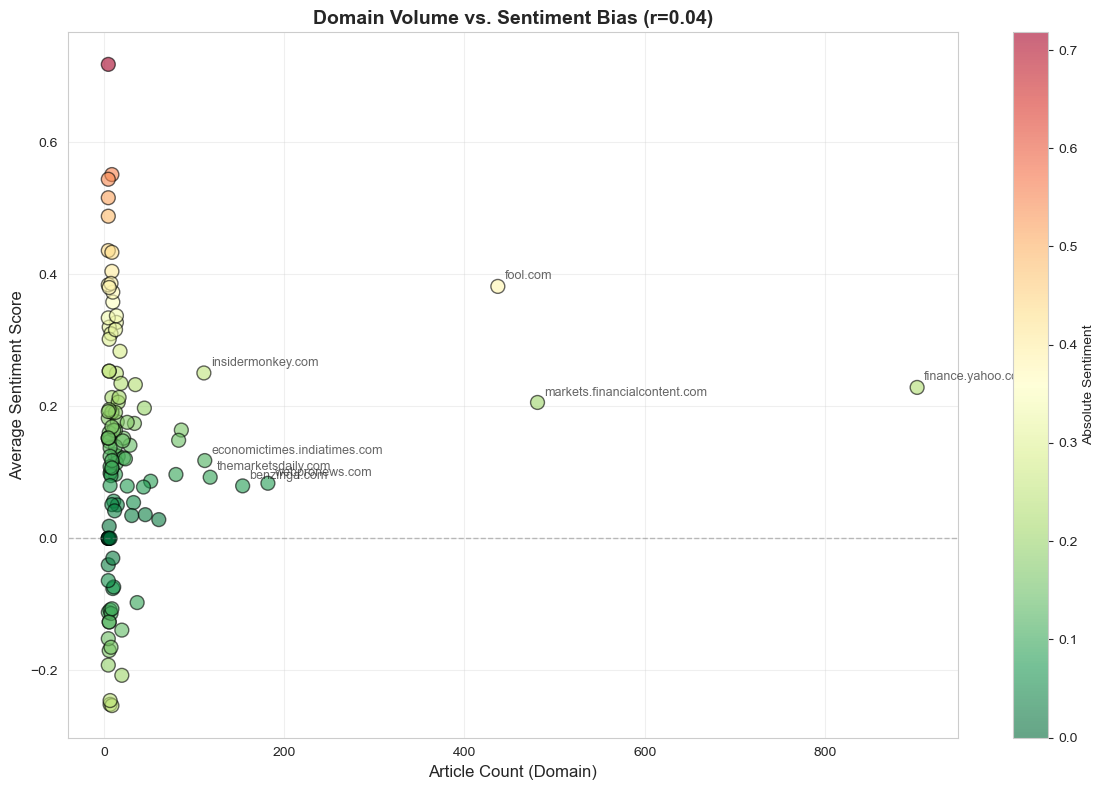

In [9]:
# Scatter plot: volume vs average sentiment
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(domain_stats['article_count'], 
                     domain_stats['avg_sentiment'],
                     s=100, alpha=0.6, c=domain_stats['abs_sentiment'], 
                     cmap='RdYlGn_r', edgecolors='black')

# Annotate top domains
top_annotate = domain_stats.nlargest(8, 'article_count').index
for domain in top_annotate:
    row = domain_stats.loc[domain]
    ax.annotate(domain, 
                xy=(row['article_count'], row['avg_sentiment']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.7)

ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Article Count (Domain)', fontsize=12)
ax.set_ylabel('Average Sentiment Score', fontsize=12)
ax.set_title(f'Domain Volume vs. Sentiment Bias (r={correlation:.2f})', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Sentiment', fontsize=10)

plt.tight_layout()
plt.show()

# **Domain x Ticker Analysis**
What companies are the most 'relevant' tickers talking about

In [12]:
# Identify domains with strong ticker preferences
top_10_domains = domain_counts.head(10).index
for domain in top_10_domains:
    domain_df = df[df['domain'] == domain]
    ticker_dist = domain_df['ticker'].value_counts()
    top_ticker = ticker_dist.index[0]
    top_pct = (ticker_dist.iloc[0] / len(domain_df) * 100)
    
    if top_pct > 30:  # Flag if > 30% of articles focus on one ticker
        print(f"{domain:30s} heavily covers {top_ticker} ({top_pct:.1f}% of articles)")

finance.yahoo.com              heavily covers NVDA (43.3% of articles)
tickerreport.com               heavily covers GOOGL (30.1% of articles)


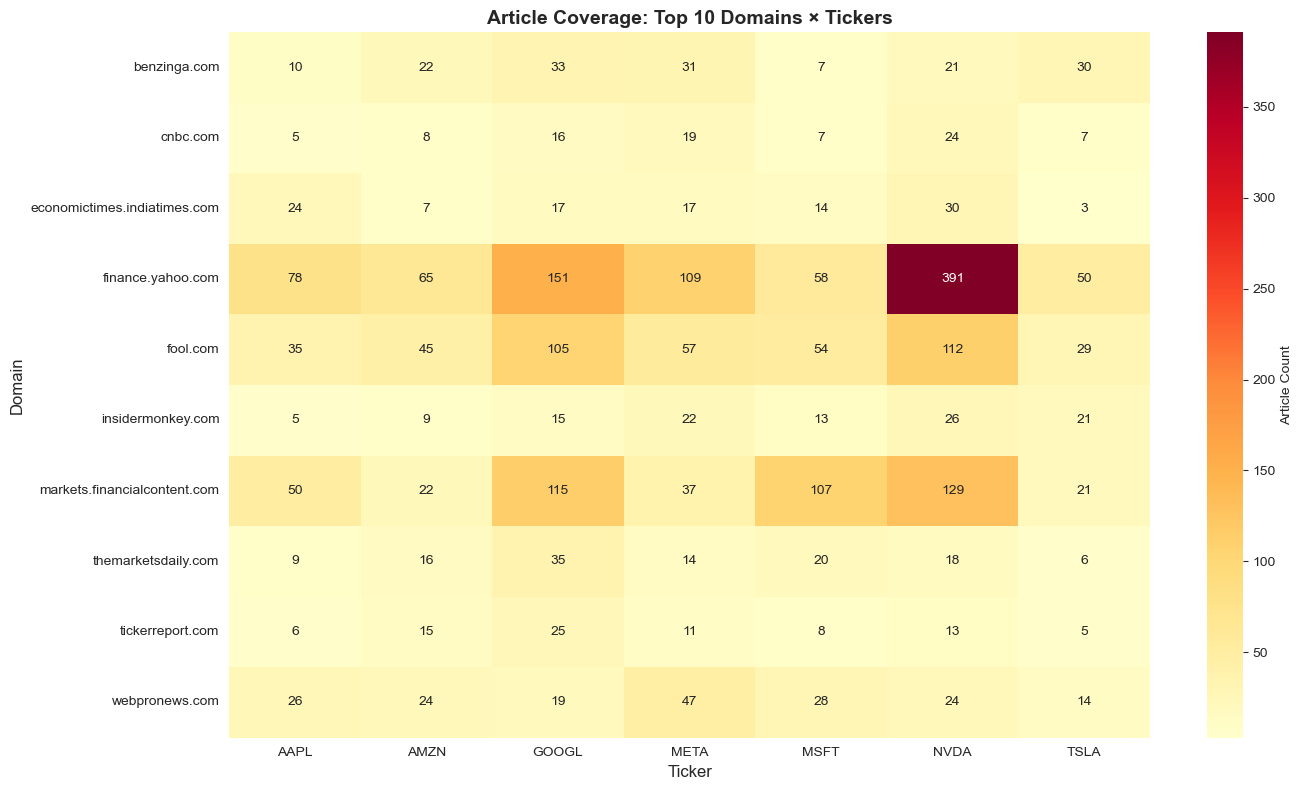

In [13]:
# Domain-ticker heatmap (top 10 domains only)
top_10_domains = domain_counts.head(10).index
df_top10 = df[df['domain'].isin(top_10_domains)]

# Create pivot table
domain_ticker_matrix = df_top10.pivot_table(
    index='domain', 
    columns='ticker', 
    values='url', 
    aggfunc='count',
    fill_value=0
)

# Heatmap
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(domain_ticker_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Article Count'}, ax=ax)
ax.set_title('Article Coverage: Top 10 Domains × Tickers', fontsize=14, fontweight='bold')
ax.set_xlabel('Ticker', fontsize=12)
ax.set_ylabel('Domain', fontsize=12)
plt.tight_layout()
plt.show()

In [14]:
# Identify domains with strong ticker preferences
for domain in top_10_domains:
    domain_df = df[df['domain'] == domain]
    ticker_dist = domain_df['ticker'].value_counts()
    top_ticker = ticker_dist.index[0]
    top_pct = (ticker_dist.iloc[0] / len(domain_df) * 100)
    
    if top_pct > 40:  # Flag if > 40% of articles focus on one ticker
        print(f"WARNING: {domain:30s} heavily covers {top_ticker} ({top_pct:.1f}% of articles)")

## **Articles with "extreme" sentiment behavior**

In [15]:
#  Flags sources with extreme sentiment behavior
# Criteria:
# 1. >60% of articles are non-neutral (opinionated sources)
# 2. Avg sentiment magnitude > 0.5 (strongly biased)
# 3. At least 10 articles (enough sample)

extreme_sources = domain_sentiment[
    (domain_sentiment['pct_with_sentiment'] > 0.60) &
    (domain_sentiment['avg_sentiment'].abs() > 0.5) &
    (domain_sentiment['article_count'] >= 10)
].sort_values('avg_sentiment', ascending=False)

print("\n" + "=" * 70)
print("SOURCES WITH EXTREME SENTIMENT BEHAVIOR")
print("Criteria: >60% non-neutral, |avg_sentiment| > 0.5, 10+ articles")
print("=" * 70)

if len(extreme_sources) > 0:
    print(f"\nFound {len(extreme_sources)} extreme sources:\n")
    print(extreme_sources[['avg_sentiment', 'std_sentiment', 'article_count', 'pct_with_sentiment']].to_string())
else:
    print("No sources meet extreme sentiment criteria.")


SOURCES WITH EXTREME SENTIMENT BEHAVIOR
Criteria: >60% non-neutral, |avg_sentiment| > 0.5, 10+ articles
No sources meet extreme sentiment criteria.


In [16]:
# -- Additional flag: High variance sources (inconsistent sentiment) --
# High std_sentiment with sufficient volume suggests unreliable/clickbait behavior

volatile_sources = domain_sentiment[
    (domain_sentiment['std_sentiment'] > 0.6) &
    (domain_sentiment['article_count'] >= 10)
].sort_values('std_sentiment', ascending=False).head(10)

print("\n" + "=" * 70)
print("SOURCES WITH HIGH SENTIMENT VOLATILITY")
print("High std_sentiment (>0.6) suggests inconsistent editorial voice")
print("=" * 70)

if len(volatile_sources) > 0:
    print(f"\nTop {len(volatile_sources)} most volatile sources:\n")
    print(volatile_sources[['avg_sentiment', 'std_sentiment', 'article_count', 'pct_with_sentiment']].to_string())
else:
    print("\nNo sources with high sentiment volatility found.")


SOURCES WITH HIGH SENTIMENT VOLATILITY
High std_sentiment (>0.6) suggests inconsistent editorial voice

Top 10 most volatile sources:

                                      avg_sentiment  std_sentiment  article_count  pct_with_sentiment
domain                                                                                               
econotimes.com                                0.358          0.726             10               0.900
rttnews.com                                   0.176          0.693             26               0.692
thestar.com.my                                0.235          0.649             19               0.684
freemalaysiatoday.com                        -0.030          0.648             10               0.600
247wallst.com                                 0.327          0.642             14               0.786
proactiveinvestors.com                        0.283          0.617             18               0.667
marketscreener.com                            0.

## **Which domains dominate on high-volume days**

In [18]:
# -- Identify high-volume days --
# Aggregate total articles per day across all tickers
daily_totals = df.groupby('article_date').size().reset_index(name='total_articles')

# Ensure article_date is datetime after groupby
daily_totals['article_date'] = pd.to_datetime(daily_totals['article_date'])

daily_totals = daily_totals.sort_values('total_articles', ascending=False)

# Define high-volume threshold (e.g., top 25% of days)
high_volume_threshold = daily_totals['total_articles'].quantile(0.75)
high_volume_days = daily_totals[daily_totals['total_articles'] >= high_volume_threshold]['article_date']

print("=" * 70)
print("High-volume days analysis")
print("=" * 70)
print(f"High-volume threshold: {high_volume_threshold:.0f} articles/day")
print(f"Number of high-volume days: {len(high_volume_days)}")
print(f"\nTop 5 busiest days:")
for idx, row in daily_totals.head(5).iterrows():
    print(f"  {row['article_date'].date()}: {row['total_articles']} articles")

High-volume days analysis
High-volume threshold: 279 articles/day
Number of high-volume days: 8

Top 5 busiest days:
  2026-02-05: 405 articles
  2026-02-06: 352 articles
  2026-01-08: 325 articles
  2026-01-13: 322 articles
  2026-01-07: 312 articles


In [19]:
# -- Which domains dominate on high-volume days? --
# Convert high_volume_days to a list of dates for matching
high_volume_dates = high_volume_days.dt.date.tolist()

# Ensure article_date is datetime before using .dt accessor
df['article_date'] = pd.to_datetime(df['article_date'])
df['article_date_only'] = df['article_date'].dt.date

high_vol_articles = df[df['article_date_only'].isin(high_volume_dates)]
high_vol_domain_counts = high_vol_articles['domain'].value_counts().head(10)

print("\n" + "=" * 70)
print("DOMAINS DOMINATING HIGH-VOLUME DAYS")
print("=" * 70)
print(f"Articles on high-volume days: {len(high_vol_articles):,}")
print(f"Top 10 domains on busy news days:\n")
for domain, count in high_vol_domain_counts.items():
    pct = (count / len(high_vol_articles) * 100)
    print(f"{domain:40s} {count:4d} articles ({pct:5.1f}%)")

# Compare to overall top domains
print("\nComparison: Do the same domains dominate both high-volume and overall?")
overall_top5 = set(domain_counts.head(5).index)
highvol_top5 = set(high_vol_domain_counts.head(5).index)
overlap = overall_top5 & highvol_top5
print(f"Overlap between top 5 overall and top 5 on high-volume days: {len(overlap)}/5")
if len(overlap) == 5:
    print("Same sources dominate both — consistent concentration pattern")
else:
    different = highvol_top5 - overall_top5
    if different:
        print(f" Different sources emerge on busy days: {different}")
    else:
        print(f"Overlap: {overlap}")

# Clean up temp column
df = df.drop(columns=['article_date_only'])


DOMAINS DOMINATING HIGH-VOLUME DAYS
Articles on high-volume days: 2,610
Top 10 domains on busy news days:

finance.yahoo.com                         389 articles ( 14.9%)
markets.financialcontent.com              285 articles ( 10.9%)
fool.com                                  172 articles (  6.6%)
webpronews.com                            106 articles (  4.1%)
benzinga.com                               81 articles (  3.1%)
economictimes.indiatimes.com               72 articles (  2.8%)
cnbc.com                                   52 articles (  2.0%)
insidermonkey.com                          51 articles (  2.0%)
themarketsdaily.com                        41 articles (  1.6%)
marketscreener.com                         39 articles (  1.5%)

Comparison: Do the same domains dominate both high-volume and overall?
Overlap between top 5 overall and top 5 on high-volume days: 5/5
Same sources dominate both — consistent concentration pattern


## **Investigating Yahoo Finance**

In [20]:
#Basic Yahoo Finance presence
yahoo_mask = df['domain'].str.contains('yahoo', case=False, na=False)
yahoo_count = yahoo_mask.sum()
total_count = len(df)

print(f"Yahoo Finance articles: {yahoo_count:,} ({yahoo_count/total_count*100:.1f}%)")
print(f"Non-Yahoo articles: {total_count - yahoo_count:,} ({(total_count - yahoo_count)/total_count*100:.1f}%)")
print(f"\nTop 10 domains:")
print(df['domain'].value_counts().head(10))

Yahoo Finance articles: 913 (17.7%)
Non-Yahoo articles: 4,254 (82.3%)

Top 10 domains:
domain
finance.yahoo.com               902
markets.financialcontent.com    481
fool.com                        437
webpronews.com                  182
benzinga.com                    154
themarketsdaily.com             118
economictimes.indiatimes.com    112
insidermonkey.com               111
cnbc.com                         86
tickerreport.com                 83
Name: count, dtype: int64


In [ ]:
# Headline normalization function
def normalize_title(title):
    # Lowercase, strips, and collapses whitespace for headline comparison.
    if pd.isna(title):
        return ""
    return " ".join(str(title).lower().strip().split())

df['normalized_title'] = df['title'].apply(normalize_title)

In [ ]:
# Find duplicate headlines and Yahoo's role
# Group by normalized headline and ticker to find stories covered by multiple outlets
headline_groups = df.groupby(['normalized_title', 'ticker']).agg({
    'url': 'count',
    'domain': lambda x: list(x),
    'seendate': 'min'
}).rename(columns={'url': 'outlet_count'})

# Filter to headlines that appeared in multiple outlets
duplicates = headline_groups[headline_groups['outlet_count'] > 1].reset_index()
duplicates = duplicates.sort_values('outlet_count', ascending=False)

print(f"Total unique (headline, ticker) pairs: {len(headline_groups):,}")
print(f"Headlines appearing in multiple outlets: {len(duplicates):,} ({len(duplicates)/len(headline_groups)*100:.1f}%)")

if len(duplicates) > 0:
    print(f"Most syndicated headline (appeared in {duplicates.iloc[0]['outlet_count']} outlets):")
    print(f"  {duplicates.iloc[0]['normalized_title'][:100]}...")
else:
    print("No duplicate headlines found (all stories are unique per ticker)")

Total unique (headline, ticker) pairs: 5,167
Headlines appearing in multiple outlets: 0 (0.0%)

No duplicate headlines found (all stories are unique per ticker)


#### **Maybe Yahoo Finance is slightly altering headlines?** 
- Checks to see if there is a significant 'similarity' between Yahoo Finance headlines and non-Yahoo finance

In [7]:
from difflib import SequenceMatcher

def similarity_score(a, b):
    # Return similarity ratio between two strings (0.0 to 1.0)
    return SequenceMatcher(None, a, b).ratio()

# Normalize titles for comparison
df['normalized_title'] = df['title'].apply(lambda x: " ".join(str(x).lower().strip().split()) if pd.notna(x) else "")

# Separate Yahoo vs non-Yahoo
yahoo_headlines = df[df['domain'].str.contains('yahoo', case=False, na=False)][['normalized_title', 'ticker', 'seendate', 'domain']].drop_duplicates(subset=['normalized_title', 'ticker'])
non_yahoo_headlines = df[~df['domain'].str.contains('yahoo', case=False, na=False)][['normalized_title', 'ticker', 'seendate', 'domain']].drop_duplicates(subset=['normalized_title', 'ticker'])

print(f"Yahoo headlines (unique): {len(yahoo_headlines):,}")
print(f"Non-Yahoo headlines (unique): {len(non_yahoo_headlines):,}")

# Sample
sample_size = min(150, len(yahoo_headlines))
yahoo_sample = yahoo_headlines.sample(n=sample_size, random_state=42)

similar_pairs = []
threshold = 0.70  # 70% similarity threshold

for _, yahoo_row in yahoo_sample.iterrows():
    # Only compare within same ticker and similar timeframe (±3 days)
    time_window = non_yahoo_headlines[
        (non_yahoo_headlines['ticker'] == yahoo_row['ticker']) &
        (abs((non_yahoo_headlines['seendate'] - yahoo_row['seendate']).dt.days) <= 3)
    ]
    
    if len(time_window) == 0:
        continue
    
    for _, other_row in time_window.iterrows():
        sim = similarity_score(yahoo_row['normalized_title'], other_row['normalized_title'])
        if sim >= threshold:
            similar_pairs.append({
                'yahoo_headline': yahoo_row['normalized_title'][:80],
                'other_headline': other_row['normalized_title'][:80],
                'other_domain': other_row['domain'],
                'similarity': sim,
                'ticker': yahoo_row['ticker'],
                'days_apart': abs((yahoo_row['seendate'] - other_row['seendate']).days)
            })

similar_df = pd.DataFrame(similar_pairs).sort_values('similarity', ascending=False)

print(f"Found {len(similar_df)} Yahoo headlines with ≥{threshold*100:.0f}% similarity to non-Yahoo headlines")

if len(similar_df) > 0:
    print(f"\nTop 10 most similar pairs:")
    print(similar_df.head(10).to_string(index=False)) 
else:
    print("No similar headlines found at 70% threshold")

Yahoo headlines (unique): 913
Non-Yahoo headlines (unique): 4,254
Found 30 Yahoo headlines with ≥70% similarity to non-Yahoo headlines

Top 10 most similar pairs:
                                                                  yahoo_headline                                                                   other_headline    other_domain  similarity ticker  days_apart
                                    ups ( ups ) q1 2025 earnings call transcript                                     ups ( ups ) q2 2025 earnings call transcript        fool.com    0.977273   AMZN           0
us companies accused of ai washing in citing artificial intelligence for job los us companies accused of ai washing in citing artificial intelligence for job los theguardian.com    0.943182   AMZN           0
                      arm holdings shares fall as licensing sales miss estimates                        arm holdings shares fall as licensing sales miss forecast          rte.ie    0.904348   AAPL           0
 

## **Initial observations and Findings**

### Coverage Concentration
- **Severe concentration risk**: Top 5 domains account for 41% of all articles, top 10 account for 51%
- **finance.yahoo.com dominates at 18%** of total coverage
- **NVIDIA** is highly covered in these articles when compared to other companies

### High-Volume Day Behavior
- Same top domains dominate both regular and high-volume days
- No evidence of niche sources "spiking" coverage during breaking news
